In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "G2-like"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = False

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
2274,orange1.1g038268m,MENVTDTVEISSDDNKSNESGTQAFQKCSSFDLNEEAAMDDAENDN...,260,1
1332,XP_009105367.1,MAENMVNLTKNIIPESTGVILLIDHDAASVASLIPMLKQRSHKDVM...,593,1
4646,Manes.08G062200.1.p,MRDDDSNWFSRWEEELPSPEELMPLSQTLITPDLALAFDIRNPTNT...,324,1
5411,XP_009602580.1,MEPINPSLAGKQRLRWTHELHERFVDAVAQLGGPDRATPKGVLRVM...,295,1
17842,XP_010912156.1,MDSTWIDHPSLSLDLNVGSLRFPDEVSKELPRSPKHEGEEFLMKRE...,304,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 2274 to 4011
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   object
 1   sequence  5000 non-null   object
 2   length    5000 non-null   int64 
 3   class     5000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.3+ KB


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1457,0.003021,0.000000,0.006042,0.009063,0.003021,0.000000,0.003021,0.006042,0.000000,0.003021,...,0.0,0.003021,0.000000,0.006042,0.003021,0.000000,0.003021,0.0,0.0,0.0
3486,0.002212,0.002212,0.011062,0.002212,0.002212,0.002212,0.004425,0.004425,0.004425,0.002212,...,0.0,0.002212,0.000000,0.000000,0.004425,0.000000,0.000000,0.0,0.0,0.0
3049,0.009421,0.000000,0.004038,0.004038,0.001346,0.009421,0.001346,0.004038,0.006729,0.002692,...,0.0,0.001346,0.000000,0.001346,0.001346,0.000000,0.001346,0.0,0.0,0.0
1253,0.000000,0.003922,0.007843,0.000000,0.000000,0.000000,0.003922,0.000000,0.007843,0.007843,...,0.0,0.000000,0.000000,0.003922,0.000000,0.000000,0.000000,0.0,0.0,0.0
2224,0.002257,0.000000,0.000000,0.002257,0.002257,0.000000,0.002257,0.000000,0.000000,0.000000,...,0.0,0.004515,0.004515,0.004515,0.002257,0.002257,0.000000,0.0,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 441)
X_test: (1000, 441)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 21s 444ms/step - accuracy: 0.5625 - loss: 0.6929

38/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6427 - loss: 0.6862   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6733 - loss: 0.6767 - val_accuracy: 0.9287 - val_loss: 0.4095


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9062 - loss: 0.4399

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9215 - loss: 0.3074

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9240 - loss: 0.2926 - val_accuracy: 0.9563 - val_loss: 0.1206


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - loss: 0.2499

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9549 - loss: 0.1474

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9557 - loss: 0.1411 - val_accuracy: 0.9413 - val_loss: 0.1485


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.1047

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9721 - loss: 0.0911

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9709 - loss: 0.0921 - val_accuracy: 0.9625 - val_loss: 0.1004


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - loss: 0.1691

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9649 - loss: 0.1013

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9643 - loss: 0.1025 - val_accuracy: 0.9650 - val_loss: 0.1073


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0631

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9755 - loss: 0.0721

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9757 - loss: 0.0726 - val_accuracy: 0.9513 - val_loss: 0.1321


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0323

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9781 - loss: 0.0716

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9777 - loss: 0.0717 - val_accuracy: 0.9600 - val_loss: 0.1321


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1035

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9797 - loss: 0.0695

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9800 - loss: 0.0681 - val_accuracy: 0.9638 - val_loss: 0.1109


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0262

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0411

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0465 - val_accuracy: 0.9663 - val_loss: 0.1127


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.0599

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.0557

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9838 - loss: 0.0548 - val_accuracy: 0.9650 - val_loss: 0.1160


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0163

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0406

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0426 - val_accuracy: 0.9650 - val_loss: 0.1184


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0870

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0500

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.0501 - val_accuracy: 0.9675 - val_loss: 0.1168


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.0507

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9818 - loss: 0.0485

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.0467 - val_accuracy: 0.9688 - val_loss: 0.1208


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0751

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0373

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0393 - val_accuracy: 0.9688 - val_loss: 0.1238


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0092

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9928 - loss: 0.0260

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0273 - val_accuracy: 0.9638 - val_loss: 0.1290


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0121

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0241

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0261 - val_accuracy: 0.9513 - val_loss: 0.1495


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0092

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9943 - loss: 0.0181

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0199 - val_accuracy: 0.9588 - val_loss: 0.1451


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0963

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0453

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0400 - val_accuracy: 0.9625 - val_loss: 0.1456


Epoch 19/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0025

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0140

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0153 - val_accuracy: 0.9650 - val_loss: 0.1483


Epoch 20/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0188

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0204

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0208 - val_accuracy: 0.9650 - val_loss: 0.1536


Epoch 21/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0240

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0241

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0227 - val_accuracy: 0.9650 - val_loss: 0.1527


Epoch 22/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0134

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0138

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0143 - val_accuracy: 0.9638 - val_loss: 0.1606


Epoch 23/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0041

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0111

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0107 - val_accuracy: 0.9613 - val_loss: 0.1699



[Train Accuracy: 99.78% - Test Accuracy: 95.70%]


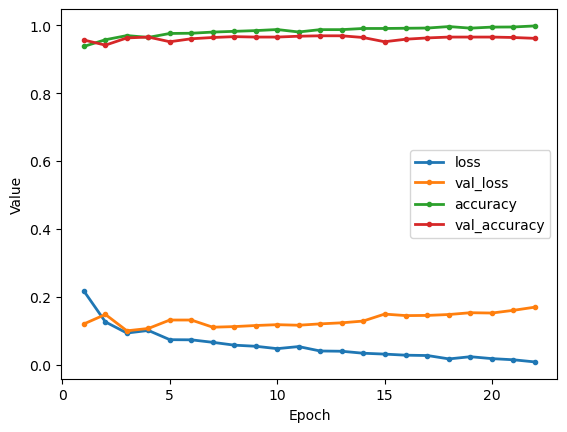

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
2776,0.000000,0.0,0.000000,0.002890,0.000000,0.000000,0.000000,0.0,0.0,0.00578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,0.006579,0.0,0.002193,0.002193,0.000000,0.002193,0.002193,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3247,0.000000,0.0,0.000000,0.000000,0.005128,0.000000,0.005128,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2299,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3025,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8705)
X_test: (1000, 8705)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,228,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,272,001 (8.67 MB)

 Trainable params: 2,272,001 (8.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.5781 - loss: 0.6931

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5318 - loss: 0.6927   

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5341 - loss: 0.6914

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5515 - loss: 0.6887

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5780 - loss: 0.6829

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6050 - loss: 0.6721

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6191 - loss: 0.6637 - val_accuracy: 0.9600 - val_loss: 0.2178


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9688 - loss: 0.2020

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9724 - loss: 0.1719 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9764 - loss: 0.1467

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9788 - loss: 0.1316

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9799 - loss: 0.1209

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9806 - loss: 0.1137

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9809 - loss: 0.1093 - val_accuracy: 0.9850 - val_loss: 0.0479


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0479

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9928 - loss: 0.0220 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9939 - loss: 0.0190

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9944 - loss: 0.0177

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9945 - loss: 0.0173

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9946 - loss: 0.0169

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9946 - loss: 0.0166 - val_accuracy: 0.9900 - val_loss: 0.0378


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0018

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0047 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0046

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0047

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0050

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0051

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0052 - val_accuracy: 0.9862 - val_loss: 0.0398


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0027

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0036 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0030

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0034

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0038

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0039

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0038 - val_accuracy: 0.9887 - val_loss: 0.0395


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 5.5868e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4593e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013    

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0016

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0018

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9850 - val_loss: 0.0634


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.3284e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2760e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5359e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6273e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6834e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7123e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5232e-04 - val_accuracy: 0.9875 - val_loss: 0.0561


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.2755e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1804e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010    

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9900 - val_loss: 0.0569


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0012

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9875 - val_loss: 0.0463


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.7893e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0332e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0223e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 3.3237e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 7.6062e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0012    

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9800 - val_loss: 0.1049


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.4815e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0018     

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0034

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0040

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0040

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0040

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0040 - val_accuracy: 0.9787 - val_loss: 0.0730


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 9.8426e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0018     

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2651e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8398e-04 - val_accuracy: 0.9875 - val_loss: 0.0543


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.0126e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0255e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0677e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1057e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1273e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1392e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1468e-04 - val_accuracy: 0.9875 - val_loss: 0.0567



[Train Accuracy: 100.00% - Test Accuracy: 97.90%]


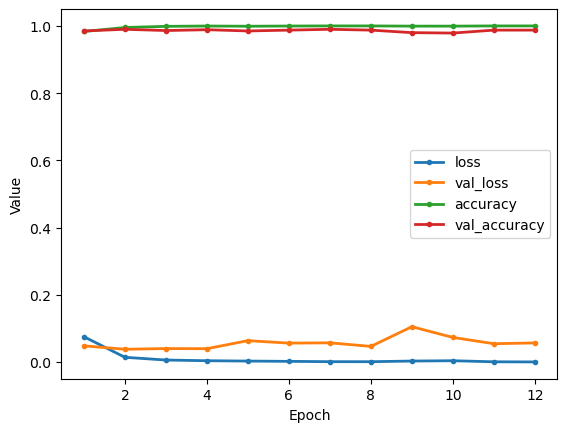

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYL,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYY
2776,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,0.0,0.0,0.0,0.002198,0.0,0.002198,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3247,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2299,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3025,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      36,634,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,675,329 (139.91 MB)

 Trainable params: 36,675,329 (139.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 30s 629ms/step - accuracy: 0.5156 - loss: 0.6931

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.4961 - loss: 0.6932 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.4922 - loss: 0.6932

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.4883 - loss: 0.6932

 5/50 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.4900 - loss: 0.6932

 6/50 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4921 - loss: 0.6932

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4945 - loss: 0.6931

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4976 - loss: 0.6931

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5004 - loss: 0.6931

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5033 - loss: 0.6930

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5064 - loss: 0.6930

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5092 - loss: 0.6929

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5118 - loss: 0.6929

14/50 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5144 - loss: 0.6928

15/50 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5169 - loss: 0.6928

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5190 - loss: 0.6927

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5206 - loss: 0.6926

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5220 - loss: 0.6925

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5230 - loss: 0.6924

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5240 - loss: 0.6923

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5250 - loss: 0.6922

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5259 - loss: 0.6921

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5266 - loss: 0.6920

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5277 - loss: 0.6919

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.5292 - loss: 0.6917

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5312 - loss: 0.6916

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5334 - loss: 0.6914

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5357 - loss: 0.6913

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5381 - loss: 0.6911

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5406 - loss: 0.6909

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5434 - loss: 0.6907

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5463 - loss: 0.6905

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5494 - loss: 0.6902

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.5526 - loss: 0.6899

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5558 - loss: 0.6896

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5590 - loss: 0.6893

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5623 - loss: 0.6890

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5656 - loss: 0.6887

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5689 - loss: 0.6883

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5722 - loss: 0.6879

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5755 - loss: 0.6874

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5788 - loss: 0.6870

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5821 - loss: 0.6865

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5854 - loss: 0.6859

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5886 - loss: 0.6854

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5918 - loss: 0.6847

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5949 - loss: 0.6841

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5980 - loss: 0.6834

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6011 - loss: 0.6827

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6042 - loss: 0.6819

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.6071 - loss: 0.6812 - val_accuracy: 0.9800 - val_loss: 0.4340


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 1.0000 - loss: 0.4218

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9961 - loss: 0.4191 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.9922 - loss: 0.4146

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9883 - loss: 0.4097

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9856 - loss: 0.4053

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9837 - loss: 0.4004

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9828 - loss: 0.3951

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9811 - loss: 0.3902

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9799 - loss: 0.3857

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9792 - loss: 0.3811

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9788 - loss: 0.3764

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9785 - loss: 0.3717

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9783 - loss: 0.3669

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9782 - loss: 0.3621

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9782 - loss: 0.3571

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9782 - loss: 0.3522

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9782 - loss: 0.3474

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9782 - loss: 0.3426

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9782 - loss: 0.3380

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9782 - loss: 0.3335

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9783 - loss: 0.3289

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9784 - loss: 0.3246

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9785 - loss: 0.3203

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9787 - loss: 0.3161

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9789 - loss: 0.3120

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9791 - loss: 0.3080

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9792 - loss: 0.3040

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9794 - loss: 0.3002

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9795 - loss: 0.2965

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9797 - loss: 0.2929

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9798 - loss: 0.2894

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9799 - loss: 0.2860

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9800 - loss: 0.2827

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9800 - loss: 0.2795

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9801 - loss: 0.2764

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9802 - loss: 0.2733

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9804 - loss: 0.2703

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9805 - loss: 0.2674

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9806 - loss: 0.2645

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9807 - loss: 0.2618

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9808 - loss: 0.2590

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9809 - loss: 0.2564

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9810 - loss: 0.2539

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9811 - loss: 0.2514

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9812 - loss: 0.2489

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9813 - loss: 0.2466

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9814 - loss: 0.2443

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9815 - loss: 0.2421

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9815 - loss: 0.2398

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9816 - loss: 0.2377

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.9817 - loss: 0.2356 - val_accuracy: 0.9912 - val_loss: 0.0391


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 1.0000 - loss: 0.0065

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 0.0068

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0069

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 0.0073

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0075

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 0.0077

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 0.0077

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 0.0077

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 0.0077

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0076

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0076

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0075

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0074

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0073

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0073

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0072

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0072

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0071

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0071

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0070

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0070

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0069

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0069

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0068

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0068

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0067

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0067

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0066

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0066

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0066

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0065

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0065

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0064

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0064

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0064

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0064

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0064

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0064

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0064

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0063

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9999 - loss: 0.0063

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9998 - loss: 0.0063

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9998 - loss: 0.0063

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9998 - loss: 0.0063

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9997 - loss: 0.0063

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9997 - loss: 0.0063

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9997 - loss: 0.0063

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9997 - loss: 0.0063

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9997 - loss: 0.0063

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9996 - loss: 0.0063

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9996 - loss: 0.0063 - val_accuracy: 0.9912 - val_loss: 0.0314


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 1.0000 - loss: 0.0014

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 0.0016

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0018

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0020

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0021

 6/50 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 1.0000 - loss: 0.0021

 7/50 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 1.0000 - loss: 0.0021

 8/50 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 1.0000 - loss: 0.0021

 9/50 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 1.0000 - loss: 0.0021

10/50 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 1.0000 - loss: 0.0021

11/50 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 1.0000 - loss: 0.0021

12/50 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 1.0000 - loss: 0.0021

13/50 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 1.0000 - loss: 0.0021

14/50 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 1.0000 - loss: 0.0021

15/50 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 1.0000 - loss: 0.0021

16/50 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 1.0000 - loss: 0.0021

17/50 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 1.0000 - loss: 0.0021

18/50 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 1.0000 - loss: 0.0021

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 1.0000 - loss: 0.0021

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 1.0000 - loss: 0.0021

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 0.0021

22/50 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 0.0021

23/50 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 0.0021

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 0.0021

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 0.0021

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 0.0021

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0021

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0021

29/50 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0021

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 0.0021

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 0.0021

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 0.0021

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 0.0020

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 0.0020

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 0.0020

36/50 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 0.0020

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 0.0020

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 0.0020

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 0.0020

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 0.0020

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 0.0020

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 1.0000 - loss: 0.0020

43/50 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 1.0000 - loss: 0.0020

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.0000 - loss: 0.0020

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.0000 - loss: 0.0020

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 0.0020

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 0.0020

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 0.0020

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 0.0020

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 0.0020

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9875 - val_loss: 0.0388


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step - accuracy: 1.0000 - loss: 0.0014

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 0.0012 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 0.0011

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 0.0011

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0010

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0010

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 0.0011

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0011

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 0.0011

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 0.0011

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0011

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0011

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0011

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0011

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0011

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 0.0011

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 0.0011

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0011

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0011

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 0.0011

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0011

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0011

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0011

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 0.0011

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 0.0011

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 0.0011

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0011

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0011

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0011

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0011

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0011

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0011

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0011

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 0.0011

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 0.0011

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 0.0011

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 0.0011

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 0.0011

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 0.0011

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0011

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0011

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0011

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0011

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0011

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0010

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0010

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0010

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0010

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0010

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9850 - val_loss: 0.0449


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 1.0000 - loss: 3.9560e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 3.9776e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 4.0678e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 4.3086e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 4.4501e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.5904e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.6589e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.7043e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.7426e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 4.7641e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 4.7608e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.7565e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 4.7580e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 4.7499e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 4.7387e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 1.0000 - loss: 4.7424e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 1.0000 - loss: 4.7470e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 4.7543e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 4.7721e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.7855e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 4.8002e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 4.8118e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 4.8205e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 4.8344e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 4.8448e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 4.8538e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 4.8640e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 4.8713e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 4.8755e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 4.8865e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 4.8939e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 4.9059e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 4.9219e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 4.9396e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.9577e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 4.9728e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 4.9854e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 4.9968e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.0142e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.0296e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 5.0465e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.0626e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.0879e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.1110e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.1324e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 5.1517e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 5.1690e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 5.1845e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 5.1985e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 5.2113e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.2236e-04 - val_accuracy: 0.9900 - val_loss: 0.0354


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 1.0000 - loss: 3.2335e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.3873e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.7874e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.9782e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.0736e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.1001e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.1216e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.1150e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.0947e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.0880e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 4.0815e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0678e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0516e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0398e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0647e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0820e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0996e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 4.1146e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.1220e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.1387e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.1500e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.1585e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.1757e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.1876e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.1973e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.2277e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.2541e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.2776e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.2967e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.3127e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.3258e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.3363e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.3461e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.3527e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.3586e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.3627e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.3649e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.3654e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.3645e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.3625e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3593e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.3553e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.3513e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.3468e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.3426e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.3377e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.3322e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.3260e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 4.3191e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 4.3120e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 4.3051e-04 - val_accuracy: 0.9875 - val_loss: 0.0434


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 1.0000 - loss: 1.9778e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 2.9288e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.0943e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 3.1558e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.1297e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.1151e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.0716e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.0814e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.0943e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.1016e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 3.0989e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.0846e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 3.0688e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 3.0746e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 3.0754e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 3.0739e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 3.0700e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 3.0780e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 3.0787e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 3.0769e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 3.0728e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.0689e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.0653e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.0609e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.0556e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.0494e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.0442e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.0381e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.0313e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.0235e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.0169e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.0124e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.0071e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.0047e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.0020e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.9987e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.9956e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.9915e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.9882e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.9842e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 2.9817e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 2.9788e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 2.9754e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 2.9717e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 2.9678e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 2.9633e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 2.9589e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 2.9540e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 2.9494e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 2.9445e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.9399e-04 - val_accuracy: 0.9862 - val_loss: 0.0464


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 1.0000 - loss: 2.7630e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 2.5947e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 2.4474e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.3492e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 2.2805e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 2.2435e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 2.2085e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 2.1738e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 2.1560e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 2.1414e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 2.1275e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 2.1155e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 2.1077e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 2.1003e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 2.0988e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.0926e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.0833e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 2.0735e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 2.0638e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 2.0563e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 2.0549e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 2.0543e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 2.0550e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 2.0757e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 2.0944e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 2.1107e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 2.1248e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 2.1383e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 2.1501e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 2.1609e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 2.1704e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 2.1785e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 2.1850e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 2.1913e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 2.1972e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 2.2021e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 2.2064e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.2108e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 2.2140e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 2.2168e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.2209e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 2.2245e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 2.2289e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 2.2324e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.2355e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.2381e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.2400e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.2420e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 2.2441e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.2460e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.2479e-04 - val_accuracy: 0.9887 - val_loss: 0.0421


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 15s 326ms/step - accuracy: 1.0000 - loss: 2.5237e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.1382e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.9215e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.7959e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.7655e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.7228e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.7564e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.7686e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.7824e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.7881e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.7868e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.7797e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.7723e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.7716e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.7711e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.7702e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.7687e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.7770e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.7885e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.7983e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.8053e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.8123e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.8170e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.8193e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.8198e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.8209e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.8230e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.8239e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.8242e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8237e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8234e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8231e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8218e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8204e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8183e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8156e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8126e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.8089e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.8051e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.8014e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.7979e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.7942e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.7907e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.7873e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.7839e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.7805e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.7771e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.7735e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.7700e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.7662e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.7625e-04 - val_accuracy: 0.9850 - val_loss: 0.0501


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 1.0000 - loss: 6.0996e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 6.9853e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 7.5917e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 7.9747e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 8.0926e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 8.2603e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 8.3728e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.5349e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.6555e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 8.7428e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 8.8033e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.8618e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.8860e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.8919e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.9144e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.9271e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 9.0075e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 9.0769e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 9.1970e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 9.2927e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 9.4073e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 9.5034e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 9.5943e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 9.6814e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 9.7549e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 9.8307e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 9.8921e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 9.9529e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.0008e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.0074e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.0131e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.0195e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.0267e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.0335e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.0441e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.0540e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.0627e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.0708e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.0781e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.1002e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.1207e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.1400e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.1581e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.1746e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.1898e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.2038e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.2231e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.2410e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.2578e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.2736e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.2887e-04 - val_accuracy: 0.9837 - val_loss: 0.0567


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 1.0000 - loss: 6.5885e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 6.6711e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.5960e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 6.9120e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 7.2389e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.3859e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 7.4618e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 7.5356e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 7.5583e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.5675e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.6391e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 7.7346e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 7.8460e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.9426e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 8.4153e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.7970e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 9.1054e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 9.3492e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 9.5611e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.7392e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 9.8890e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.0010e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.0106e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.0194e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.0260e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.0315e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.0362e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.0414e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.0454e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.0487e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.0519e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.0562e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.0599e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.0631e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.0663e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0692e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0714e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0737e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0757e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0775e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0790e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0803e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0811e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0821e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0829e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0834e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0836e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.0838e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.0845e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.0849e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.0853e-04 - val_accuracy: 0.9875 - val_loss: 0.0482



[Train Accuracy: 100.00% - Test Accuracy: 97.70%]


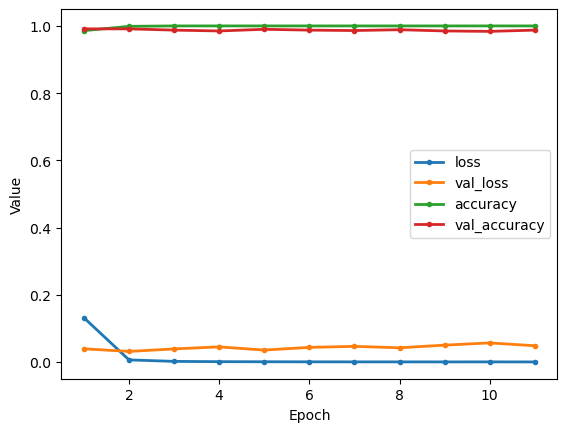

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [26]:
report.save()

Report saved as Output/Reports/G2-like/report_13TYGCVK.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [28]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [30]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [31]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [32]:
# END

In [33]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################